# Homework 1 - Supervised Deep Learning

---
A.A. 2021/22, Borella Lorenzo, mat. 2012266
---


# 1) Regression task

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision

from skorch import NeuralNetRegressor
from sklearn.model_selection import GridSearchCV,KFold

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

## 1.1) Data Loading

I decided to load the data as numpy ndarrays, since I will use the scikitlearn function KFold in the following and I found more comfortable to work in this format. I printed the dimensions of both datasets to get an idea about the amount of data I was dealing with and I plotted their distribution in the x-y plane, highlighting the differences between test and train points.

Training set of dimension:(100, 2)
Test set of dimension:(100, 2)


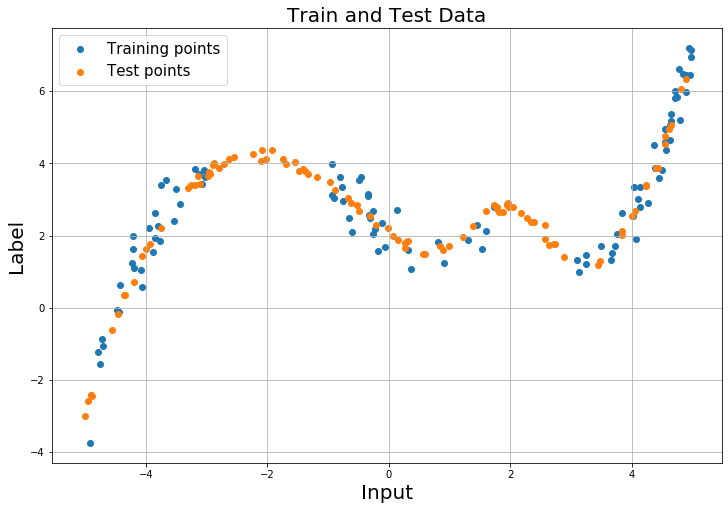

In [2]:
#filenames
train_file = "regression_dataset/train_data.csv"
test_file = "regression_dataset/test_data.csv"

#read files as np.ndarrays
training_set = np.genfromtxt(train_file, delimiter = ',', skip_header = 1)
test_set = np.genfromtxt(test_file, delimiter = ',', skip_header = 1)

print(f"Training set of dimension:{np.shape(training_set)}")
print(f"Test set of dimension:{np.shape(test_set)}")

#Plot training and Test Data
fig = plt.figure(figsize=(12,8))
plt.scatter(training_set[:,0], training_set[:,1], label='Training points')
plt.scatter(test_set[:,0], test_set[:,1], label= "Test points")
plt.grid()
plt.title("Train and Test Data",fontsize=20)
plt.xlabel('Input', fontsize=20)
plt.ylabel('Label',fontsize=20)
plt.legend(fontsize=15)
plt.show()

## 1.2) Classes and function definitions

### 1.2.1) Neural Network Class

Here's the definition of the Neural Network Class that I will use throughout the whole homework.

Since I wanted to test different Neural Network architectures, I defined the class in a way that allows me to initialize the NN with two or three hidden layers. The class defines a Neural Network with fully connected layers. While the Input and Output layers will always be made of one single neuron, the hidden layers will have variable number of neurons; the architectures with three hidden layers will have a non-zero value of Nh3, while all the other cases will represent NNs with only two hidden layers.


I inserted the possibility to modify the Dropout probability into the definition of the class. The input parameter $\texttt{p_drop}$ allows me to tune differently the probability for a neuron to be dropped during the initialization of the network; I set to 0.5 the default value of such parameter.


In [3]:
class Net(nn.Module):
    
    def __init__(self, Ni, Nh1, Nh2, Nh3, No, p_drop=0.5): 
    
        super().__init__()
        
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        
        #if third layer is present
        if(Nh3!=0):
            self.fc3 = nn.Linear(in_features=Nh2, out_features=Nh3)
            self.out = nn.Linear(in_features=Nh3, out_features=No)
        else:
            self.out = nn.Linear(in_features=Nh2, out_features=No)
        self.act = nn.Sigmoid()
        
        # Define proportion or neurons to dropout
        self.dropout = nn.Dropout(p_drop)
        
        print('Network Initialized')
        
    def forward(self, x, additional_layer=True):
        x = self.act(self.fc1(x))
        x = self.dropout(x)
        x = self.act(self.fc2(x))
        x = self.dropout(x)
        
        #if third layer is present
        if(additional_layer==True): 
            x = self.act(self.fc3(x))
            x = self.dropout(x)
            
        x = self.out(x)
        return x

### 1.2.2) Dataset Class, Transforms and Device

The Dataset object is created starting from the numpy ndarrays containing the data.

The only transformation defined for this process is the usual ToTensor() class that allows us to move from the ndarray to tensor type, useful in the following to treat the data in the Pytorch framework. 

Eventually I inserted in this cell the device selection line, useful to check on which processor I am going to run my program. I have written and initially tested the whole notebook on my computer, then I moved it into GoogleColab looking for better time performances but without success. Every cell in the following has therefore been run on my own machine.

In [4]:
class CsvDataset(Dataset):

    def __init__(self, matrix, transform=None):
    
        #define transformation
        self.transform = transform
            
        # Get x and y values from each line and append to self.data
        self.data = []
        for elem in matrix:
            self.data.append((float(elem[0]), float(elem[1])))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample
    
    
class ToTensor(object):

    def __call__(self, sample):
        x, y = sample
        return (torch.tensor([x]).float(),
                torch.tensor([y]).float())
    
    
composed_transform = transforms.Compose([ToTensor()])

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cpu


### 1.2.3) Neural Network: initialization function

To simplify the code in the following, I defined a Function that initializes the NN structure and moves it to the device. The input parameters of this function are the number of neurons (Ni, Nh1, Nh2, Nh3 No), the kind of loss function used evaluate the performances of the NN and the Dropout probability value $\texttt{p_drop}$.

In [5]:
#define initialization function
def initialization(Ni, Nh1, Nh2, Nh3, No, loss_function, p_drop):

    # Initialize the network
    torch.manual_seed(0)
    
    network = Net(Ni, Nh1, Nh2, Nh3, No, p_drop)
        
    network.to(device)

    # Define the loss function
    loss_fn = loss_function 

    return network

### 1.2.4) Neural Network: Training function

I defined the Training function in a way that allows me to perform cross validation over all the data I am dealing with. I'm using the Skitlearn built-in function KFold to divide the training data in four different shuffled folds.

The training function returns the values of training and validation losses; they will be used in the following to show the behavior of the learning curves of the Neural Network.

The training procedure works in the following way:
1. An iteration is performed over all epochs; the maximum number of iterations is set with the $\texttt{max_epochs}$ parameter.


2. For each epoch, the training set is divided into four shuffled folds: three of them will be used for the training and the remaining one will constitute the validation set. This is repeated four times per each epoch, since the definition of training and validation folds will change as required by cross validation.


3. For each combination of training and validation folds, Dataset and Dataloader objects are defined. The batch size of the train dataloader is set to 5, therefore we will have 15 batches to cover all the training data, while the validation dataloader is treated as one single batch.


4. After the definition of Training and Validation Dataloaders, the NN is set into training mode and a for loop is performed on each batch. The data batch are then given to the NN and the output is stored and compared to the label batch by means of the loss function. Eventually the loss is backpropagated through the network and the weights are updated according to the optimizer's step.


5. After the whole training dataloader has been covered, the NN is moved into evaluation mode and the gradient tracking is disabled. The evaluation set is just used to keep track of the validation loss with the current implementation of the NN and its weights.


6. The mean loss value per each batch is stored in a list and a following mean value is computed on the loss values of each fold coming from cross validation. The final loss values are stored in $\texttt{train_loss_log}$ and $\texttt{val_loss_log}$ lists to eventually plot the learning curves.




In [6]:
def new_training(NN, num_epochs, loss_function, additional_layer=False):
    
    #train and validation losses computed as KFold means at each epoch
    train_loss_log = []
    val_loss_log = []
    
    kf = KFold(n_splits=4, shuffle=True)
    
    for epoch_num in range(num_epochs):
        
        
        kf_train_loss = []
        kf_val_loss = []
    
        #KFold splitting training_dataset into train(3/4) and validation(1/4)
        for train_index, val_index in kf.split(training_set):
        
            #converting to Dataset Class
            train_dataset = CsvDataset(training_set[train_index,:], transform=composed_transform) #75 items
            val_dataset = CsvDataset(training_set[val_index,:], transform=composed_transform) #25 items

            #Converting to Dataloader Class
            train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True, num_workers=0)
            val_dataloader  = DataLoader(val_dataset,  batch_size=len(val_dataset), shuffle=False, num_workers=0)

            ### TRAIN
            NN.train() # Training mode
            
            # Move data to device
            train_loss = []
            for sampled_batch in train_dataloader: #5 items per batch
                x_batch = sampled_batch[0].to(device)
                label_batch = sampled_batch[1].to(device)
            
                # Forward pass
                out = NN(x_batch,additional_layer)

                # Compute loss
                loss = loss_function(out, label_batch)

                # Backpropagation
                NN.zero_grad()
                loss.backward()

                # Update the weights
                optimizer.step()

                # Save train loss for this batch
                loss_batch = loss.detach().cpu().numpy()
                train_loss.append(loss_batch) 
            
            kf_train_loss.append(np.mean(train_loss)) 
            
            ### VALIDATION
            NN.eval() # Evaluation mode 
            
            with torch.no_grad(): # Disable gradient tracking
                
                # Move data to device
                val_loss = []
                for sampled_batch in val_dataloader:
                    x_batch = sampled_batch[0].to(device)
                    label_batch = sampled_batch[1].to(device)
                    
                    # Forward pass
                    out = NN(x_batch,additional_layer)

                    # Compute loss
                    loss = loss_function(out, label_batch)

                    # Save val loss for this batch
                    loss_batch = loss.detach().cpu().numpy()
                    val_loss.append(loss_batch)
                    
                kf_val_loss.append(np.mean(val_loss))
                
        #save mean loss values for each epoch        
        train_loss_log.append(np.mean(kf_train_loss))
        val_loss_log.append(np.mean(kf_val_loss))
        
    print("Network Trained")
        
    return [train_loss_log, val_loss_log] 

### 1.2.5) Plot learning curves, Neural Network's output and weights.

In this cell I defined a series of different functions that I will use throughout my notebook to plot different aspects of the NN study, e.g. learning curves, output, weights distribution and activation function.


In [7]:
def plot_learningcurves(train, val, hidden):
    
    # Plot losses
    plt.figure(figsize=(12,8))
    plt.semilogy(val, label='Validation loss')
    plt.semilogy(train, label='Train loss')
    plt.title(f"Learning Curves for NN: {hidden} ")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()
    plt.show()
    
def plot_output(NN,additional_layer=False):
    
    # Input
    x_vec = torch.linspace(-5,5,1000)
    x_vec = x_vec.to(device).unsqueeze(-1)

    # NN output
    NN.eval()
    with torch.no_grad(): # turn off gradients computation
        y_vec = NN(x_vec,additional_layer)
        
    # Convert x_vec and y_vec to numpy one dimensional arrays
    x_vec = x_vec.squeeze().cpu().numpy()
    y_vec = y_vec.squeeze().cpu().numpy()

    # Plot output
    plt.figure(figsize=(12,8))
    plt.plot(x_vec, y_vec, label='Network output')
    plt.scatter(test_set[:,0], test_set[:,1], label= "Test points")
    plt.scatter(training_set[:,0], training_set[:,1], label='Training points')
    plt.title("Neural Network Model")
    plt.grid()
    plt.xlabel('input')
    plt.ylabel('label')
    plt.legend()
    plt.show()
    
def plot_weights(NN,axs):
    
    #Layer 1
    h1_w = NN.fc1.weight.data.cpu().numpy()
    h1_b = NN.fc1.bias.data.cpu().numpy()

    # Layer 2
    h2_w = NN.fc2.weight.data.cpu().numpy()
    h2_b = NN.fc2.bias.data.cpu().numpy()
    
    # Layer 3
    h3_w = NN.fc3.weight.data.cpu().numpy()
    h3_b = NN.fc3.bias.data.cpu().numpy()

    # Output layer
    out_w = NN.out.weight.data.cpu().numpy()
    out_b = NN.out.bias.data.cpu().numpy()
    
    # Weights histogram
    axs[0].hist(h1_w.flatten(), 50)
    axs[0].set_title('First hidden layer weights',fontsize=20)
    axs[1].hist(h2_w.flatten(), 50)
    axs[1].set_title('Second hidden layer weights',fontsize=20)
    axs[2].hist(out_w.flatten(), 50)
    axs[2].set_title('Third hidden layer weights',fontsize=20)
    axs[3].hist(h3_w.flatten(), 50)
    axs[3].set_title('Output layer weights',fontsize=20)
    [ax.grid() for ax in axs]
    plt.tight_layout()
    plt.show()
    


## 1.3) Comparison between 3 different architectures

I decide to compare three different Neural Network architectures in order investigate the differences in their behaviour.

As a first step, I kept fixed the following set of parameters for all the three different NN:

| Parameter | Value |
| --- | --- |
| Learning Rate | 0.001 |
| Momentum | 0.0 |
| Optimizer | SGD |
| P_drop | 0.0 |
| Num_epochs | 3000 |

While keeping the above set of parameters fixed, I tested the following Neural Network Architectures:

| Input | Nh1 | Nh2 | Nh3 | Output |
| --- | --- | --- | --- | --- |
| 1 | 50 | 50 | / | 1 |
| 1 | 100 | 200 | / | 1 |
| 1 | 100 | 200 | 100 | 1 |


In [24]:
#TIME CONSUMING CELL
start_time = time.time()

#list of NN architectures
NN1 = initialization(Ni=1, Nh1=50, Nh2=50, Nh3=0, No=1, loss_function=nn.MSELoss(),p_drop=0)
NN2 = initialization(Ni=1, Nh1=100, Nh2=200, Nh3=0, No=1, loss_function=nn.MSELoss(),p_drop=0)
NN3 = initialization(Ni=1, Nh1=100, Nh2=200, Nh3=100, No=1, loss_function=nn.MSELoss(),p_drop=0)

NN = [NN1, NN2, NN3]

#empty lists of learning curves parameters
train_losses = []
test_losses = []

l=False #control variable for additional layer

#loop over the three poossible NN configurations
for i,net in enumerate(NN):
    
    if(i==2):l=True #for the third NN, allow additional layer
    
    # Define the optimizer
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.0)
    
    #train the network
    train_loss, test_loss = new_training(net, num_epochs=3000, loss_function=nn.MSELoss(), additional_layer=l)
    
    #store learning curves
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    

print("--- %s seconds ---" % (time.time() - start_time))

Network Initialized
Network Initialized
Network Initialized
Network Trained
Network Trained
Network Trained
--- 448.1309759616852 seconds ---


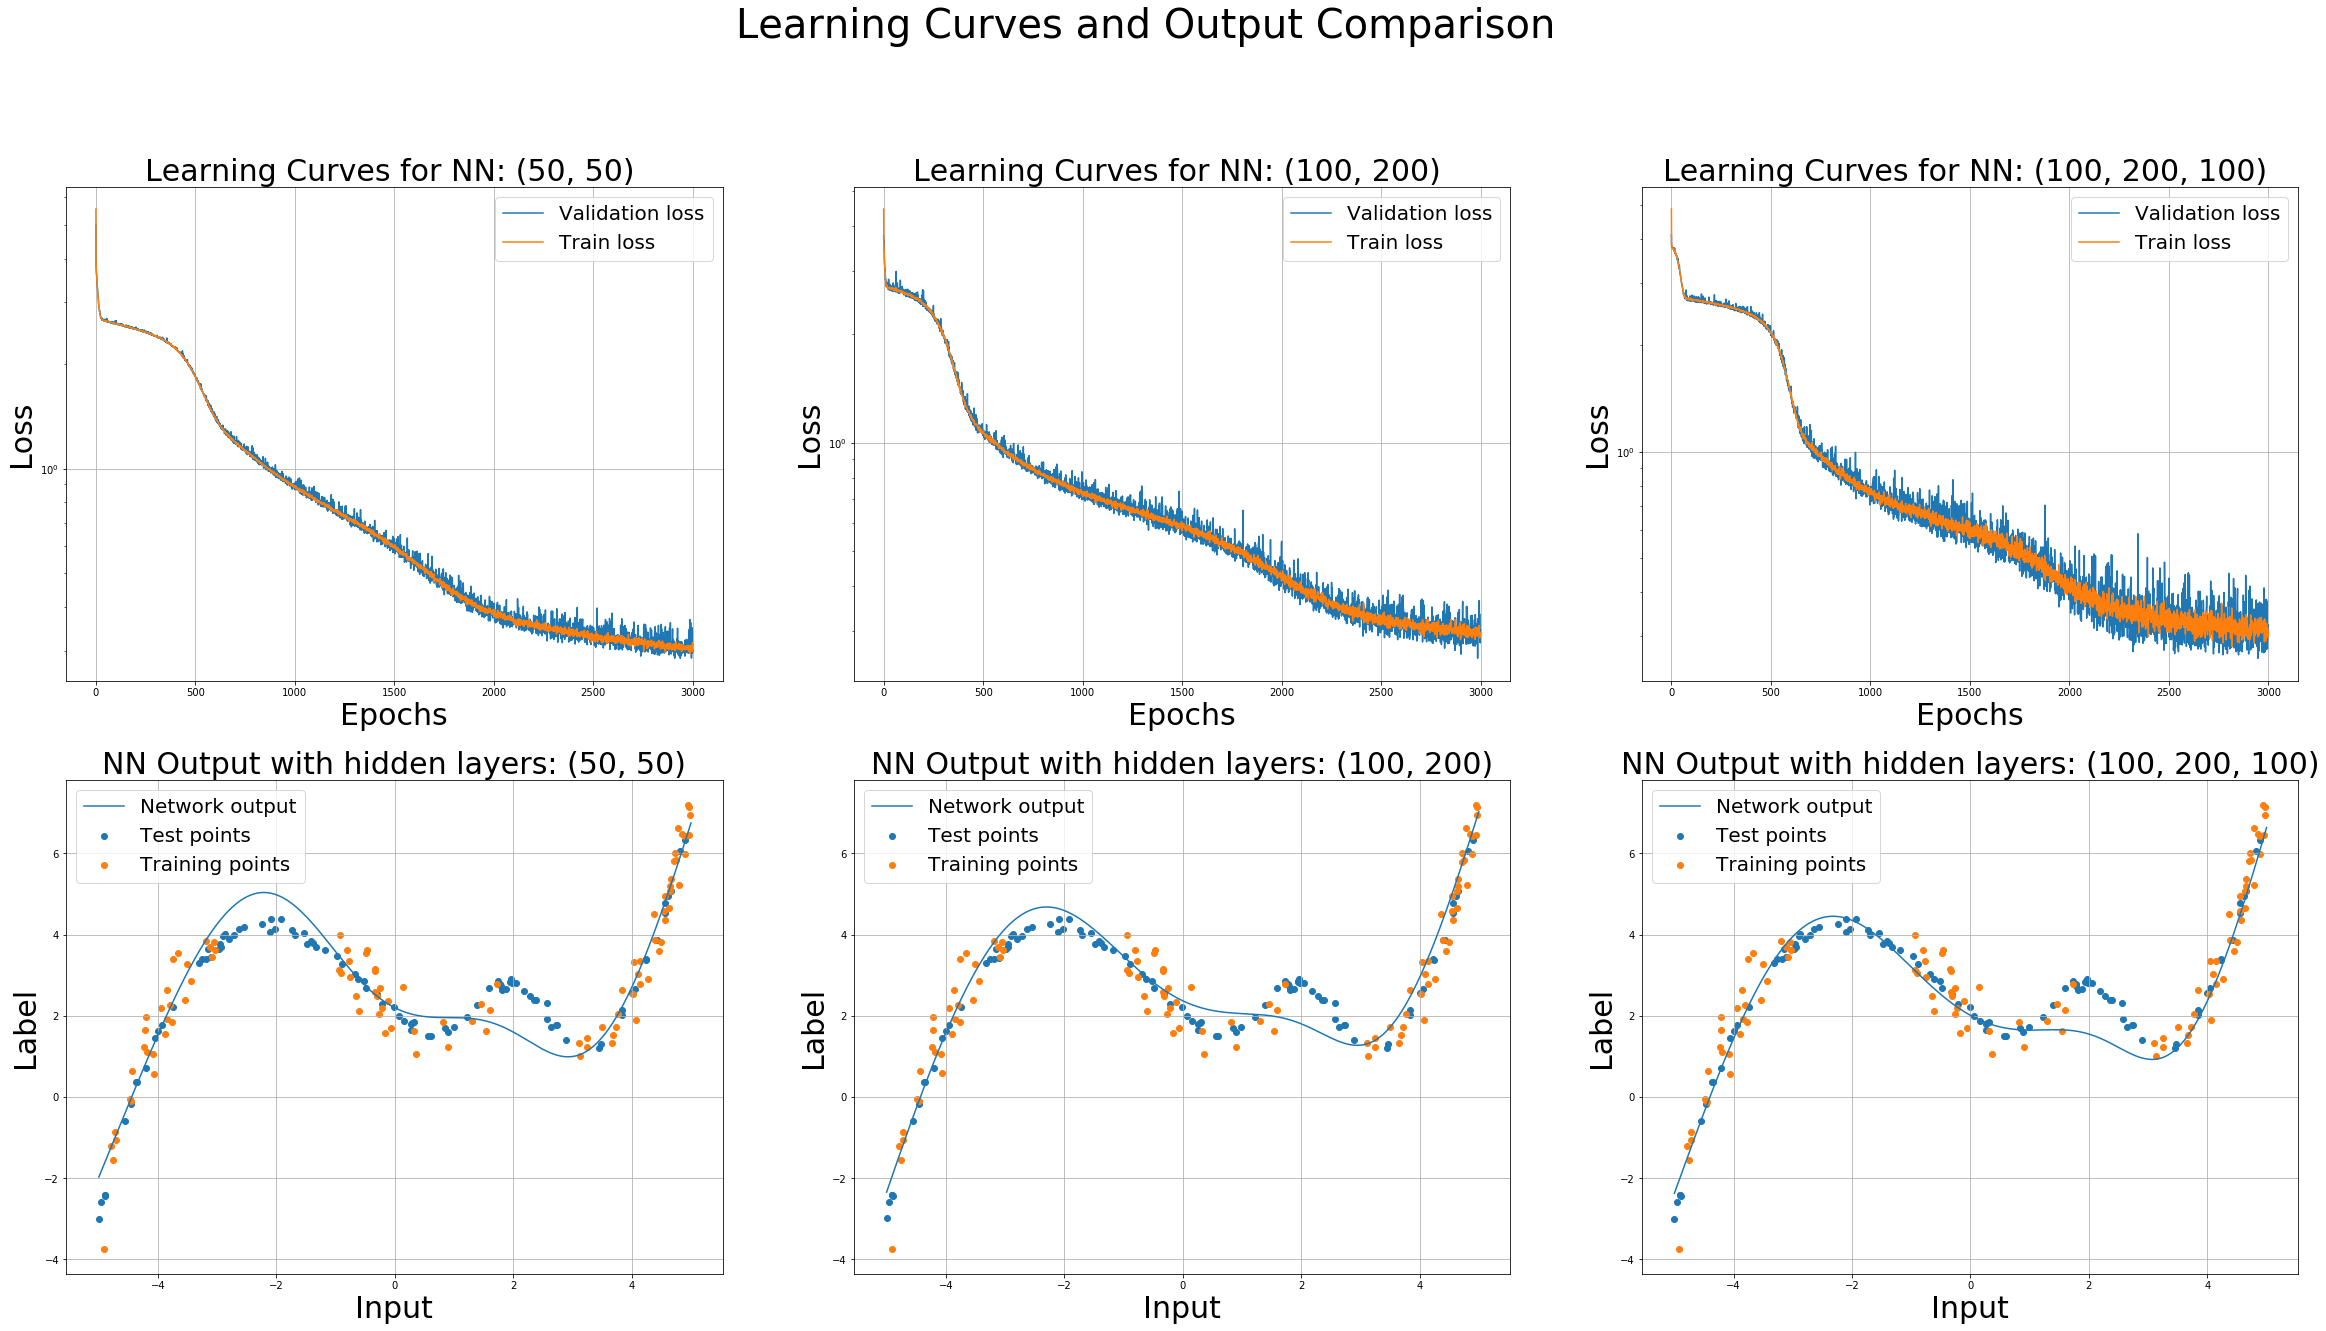

In [25]:
#architectures
arch = [(50,50), (100,200), (100,200,100)]

#big summarizing plot
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(40,20))

l=False #control variable for additional layer

for i,net in enumerate(NN):
    
    if(i==2):l=True
    
    #select losses for NN architecture
    train = train_losses[i]
    val = test_losses[i]
    hidden = arch[i]
    
    # Plot Learning curves
    ax[0,i].semilogy(val, label='Validation loss')
    ax[0,i].semilogy(train, label='Train loss')
    ax[0,i].set_title(f"Learning Curves for NN: {hidden} ", fontsize=30)
    ax[0,i].set_xlabel('Epochs', fontsize=30)
    ax[0,i].set_ylabel('Loss', fontsize=30)
    ax[0,i].grid()
    ax[0,i].legend(fontsize=20)
    
    
    # Input
    x_vec = torch.linspace(-5,5,1000)
    x_vec = x_vec.to(device).unsqueeze(-1)

    # NN output
    net.eval()
    with torch.no_grad():
        y_vec = net(x_vec,l)
        
    # Convert x_vec and y_vec to numpy one dimensional arrays
    x_vec = x_vec.squeeze().cpu().numpy()
    y_vec = y_vec.squeeze().cpu().numpy()

    # Plot NN Output
    ax[1,i].plot(x_vec, y_vec, label='Network output')
    ax[1,i].scatter(test_set[:,0], test_set[:,1], label= "Test points")
    ax[1,i].scatter(training_set[:,0], training_set[:,1], label='Training points')
    ax[1,i].set_title(f"NN Output with hidden layers: {hidden}", fontsize=30)
    ax[1,i].grid()
    ax[1,i].set_xlabel('Input', fontsize=30)
    ax[1,i].set_ylabel('Label', fontsize=30)
    ax[1,i].legend(fontsize=20)
    
plt.suptitle("Learning Curves and Output Comparison",x=0.5, y=1.005,fontsize=40)
plt.show()
    
    

Comments on the results:

* LEARNING CURVES: The learning behaviours of each neural network architecture do not present any major difference. The convergence time is mainly bounded by the choice of the optimizer (as well as other important parameters such as learning rate, momentum and p_drop) therefore it is not really modified by the choice of the architecture. Nonetheless, since the number of trainable parameters in each architecture is increasing from left to right, it makes sense to witness always noisier validation loss signals.



* OUTPUT: The qualitative evaluation of the output plots doesn't show any consistent difference between the architectures. Even thought the best looking behaviour is showed in the central plot, I decided to maintain the three hidden layers architecture for the following sections of my notebook.

## 1.4) Fixed Architecture, Explore Advanced Optimizers

I decided to keep the three layers architecture for the rest of my notebook, even though it might be over-parametrized for the problem I am facing. With this fixed architecture I made a comparison between SGD and Adam optimizers to check the differences in the convergence time of the algorithm.

### 1.4.1) Explore Optimizers: Compare SGD with different momenta

In [14]:
#computational time
start_time = time.time()

momenta = [0.1, 0.5, 0.7]

Networks = []
train_losses = []
test_losses = []

for i, m in enumerate(momenta):

    #initialize the network
    NN = initialization(Ni=1, Nh1=100, Nh2=200, Nh3=100, No=1, loss_function=nn.MSELoss(), p_drop=0)

    # Define the optimizer
    optimizer = optim.SGD(NN.parameters(), lr=1e-3, momentum=m)

    #train the network
    train_loss, test_loss = new_training(NN, num_epochs=3000, loss_function=nn.MSELoss(), additional_layer=True)
    
    #store data
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    Networks.append(NN)
    

print("--- %s seconds ---" % (time.time() - start_time))

Network Initialized
Network Trained
Network Initialized
Network Trained
Network Initialized
Network Trained
--- 471.74361515045166 seconds ---


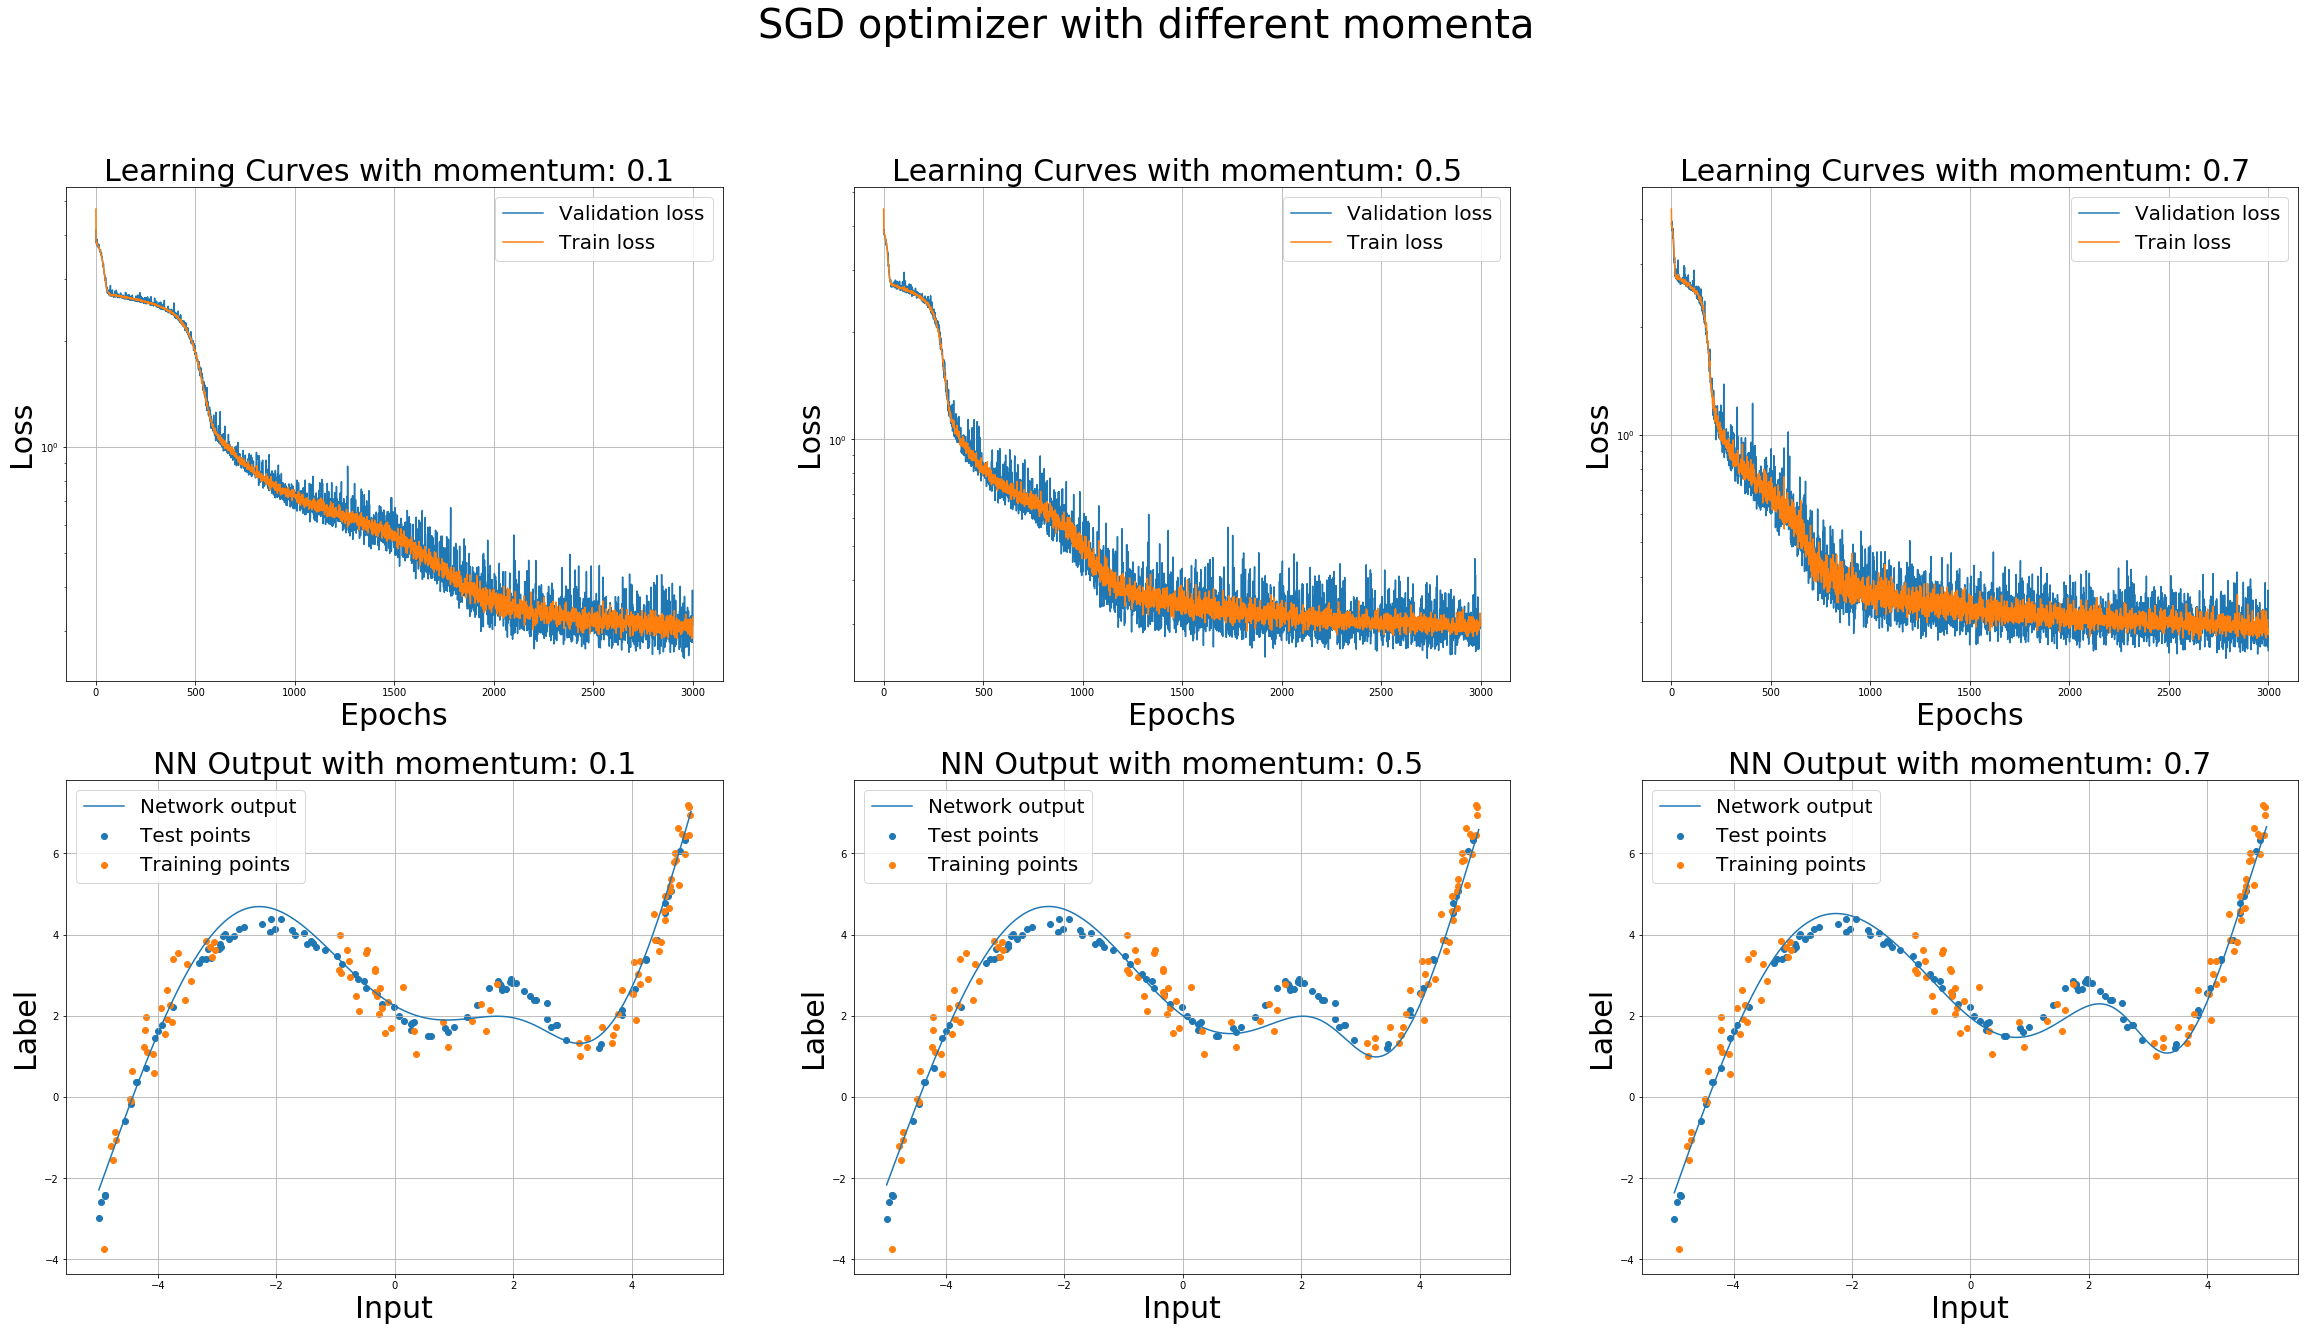

In [18]:
#big plot that compares the different p_drop values
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(40,20))

for i,m in enumerate(momenta):
    
    #select proper data
    val = test_losses[i]
    train = train_losses[i]
    net = Networks[i]
    
    # Plot Learning curves
    ax[0,i].semilogy(val, label='Validation loss')
    ax[0,i].semilogy(train, label='Train loss')
    ax[0,i].set_title(f"Learning Curves with momentum: {m} ", fontsize=30)
    ax[0,i].set_xlabel('Epochs', fontsize=30)
    ax[0,i].set_ylabel('Loss', fontsize=30)
    ax[0,i].grid()
    ax[0,i].legend(fontsize=20)
    
    # Input vector
    x_vec = torch.linspace(-5,5,1000)
    x_vec = x_vec.to(device).unsqueeze(-1)

    # Network output
    net.eval()
    with torch.no_grad(): # turn off gradients computation
        y_vec = net(x_vec,additional_layer=True)
        
    # Convert x_vec and y_vec to numpy one dimensional arrays
    x_vec = x_vec.squeeze().cpu().numpy()
    y_vec = y_vec.squeeze().cpu().numpy()

    # Plot NN Output
    ax[1,i].plot(x_vec, y_vec, label='Network output')
    ax[1,i].scatter(test_set[:,0], test_set[:,1], label= "Test points")
    ax[1,i].scatter(training_set[:,0], training_set[:,1], label='Training points')
    ax[1,i].set_title(f"NN Output with momentum: {m}", fontsize=30)
    ax[1,i].grid()
    ax[1,i].set_xlabel('Input', fontsize=30)
    ax[1,i].set_ylabel('Label', fontsize=30)
    ax[1,i].legend(fontsize=20)
    
    
plt.suptitle("SGD optimizer with different momenta",x=0.5,y=1.005,fontsize=40)
plt.show()

I compared three different momentum values for the SGD optimizer with a fixed number of epochs. All of the three final output results are a good approximation of the actual distribution of the data points. The main difference between the three lies of course in the behaviour of the learning curves. 

For low values of the momentum, a high number of epochs is needed to get to a satisfying loss result, while for higher momentum values the convergence is reached much faster. For the last plot in fact, even 1500/2000 epochs would been enough to get to a working neural network configuration.

The main drawback of SGD optimizer is that, due to its stochastic feature, the loss signals are extremely noisy: the algorithm is looking for the minimum loss following a random noise drawn pattern, therefore it might not always move in the correct minimization direction.

### 1.4.2) Explore Optimizer: Adam with adaptive learning rate

Adam optimizer should present a faster convergence with respect to the SGD results, due to its algorithmic functioning and to the adaptive learning rate. I tested its behaviour with the same number of epochs I used for the previous SGD simulations.


Network Initialized
Network Trained


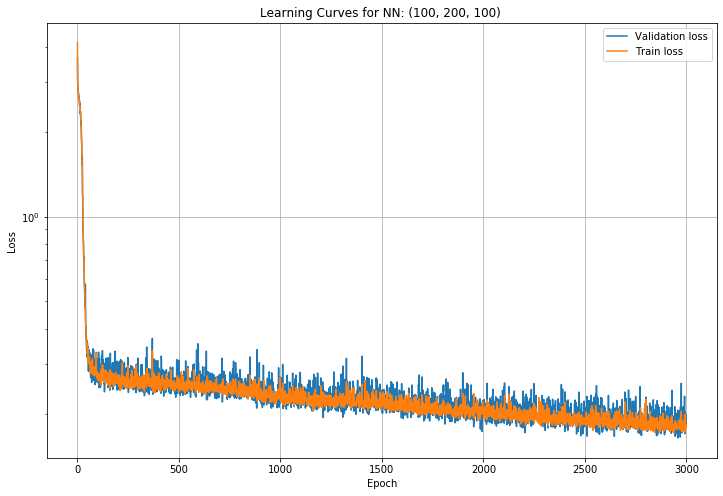

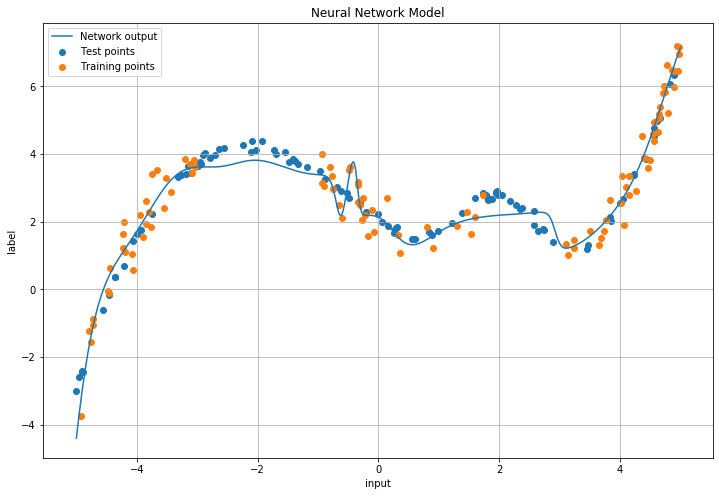

--- 292.07352089881897 seconds ---


In [19]:
#computational time
start_time = time.time()

#initialize the network
NN = initialization(Ni=1, Nh1=100, Nh2=200, Nh3=100, No=1, loss_function=nn.MSELoss(), p_drop=0)

# Define the optimizer
optimizer = optim.Adam(NN.parameters(), lr=1e-3)

#train the network
train_loss, test_loss = new_training(NN, num_epochs=3000, loss_function=nn.MSELoss(), additional_layer=True)

#plot learning curves
plot_learningcurves(train_loss, test_loss, (100, 200, 100))

#plot output
plot_output(NN,additional_layer=True)

print("--- %s seconds ---" % (time.time() - start_time))

The result clearly presents an overfitting behaviour. Adam's convergence is much faster than the one of SGD optimizer, therefore much less epochs wouold be needed in order to reach satisfying loss values.

Adam's convergence time is indeed a useful feature that I wanted to maintain for training my Neural Network.  Even though the most natural thing to avoid overfitting would have been to reduce the number of epochs, having encountered this extreme overfitting case I decided to test the behaviours of several Regularization methods that we have studied throughout the course. 

## 1.5) Fixed Architecture and Optimizer, add Regularization


### 1.5.1) Regularization: L2 penalty


I decided to keep the number of epochs fixed, as well as Adam optimizer.

I added the L2 penalty feature by setting the Adam's parameter $\texttt{weight_decay}$ with three different possible values, in order to make a comparison between the different Regularization levels.

In [26]:
#computational time
start_time = time.time()

#weight decays
weights = [1e-4, 1e-3, 1e-2]

Networks = []
train_losses = []
test_losses = []

for i,w in enumerate(weights):

    #initialize the network
    NN = initialization(Ni=1, Nh1=100, Nh2=200, Nh3=100, No=1, loss_function=nn.MSELoss(), p_drop=0)

    # Define the optimizer
    optimizer = optim.Adam(NN.parameters(), lr=0.01, weight_decay=w)

    #train the network
    train_loss, test_loss = new_training(NN, num_epochs=3000, loss_function=nn.MSELoss(), additional_layer=True)
    
    #store data
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    Networks.append(NN)


print("--- %s seconds ---" % (time.time() - start_time))

Network Initialized
Network Trained
Network Initialized
Network Trained
Network Initialized
Network Trained
--- 686.994215965271 seconds ---


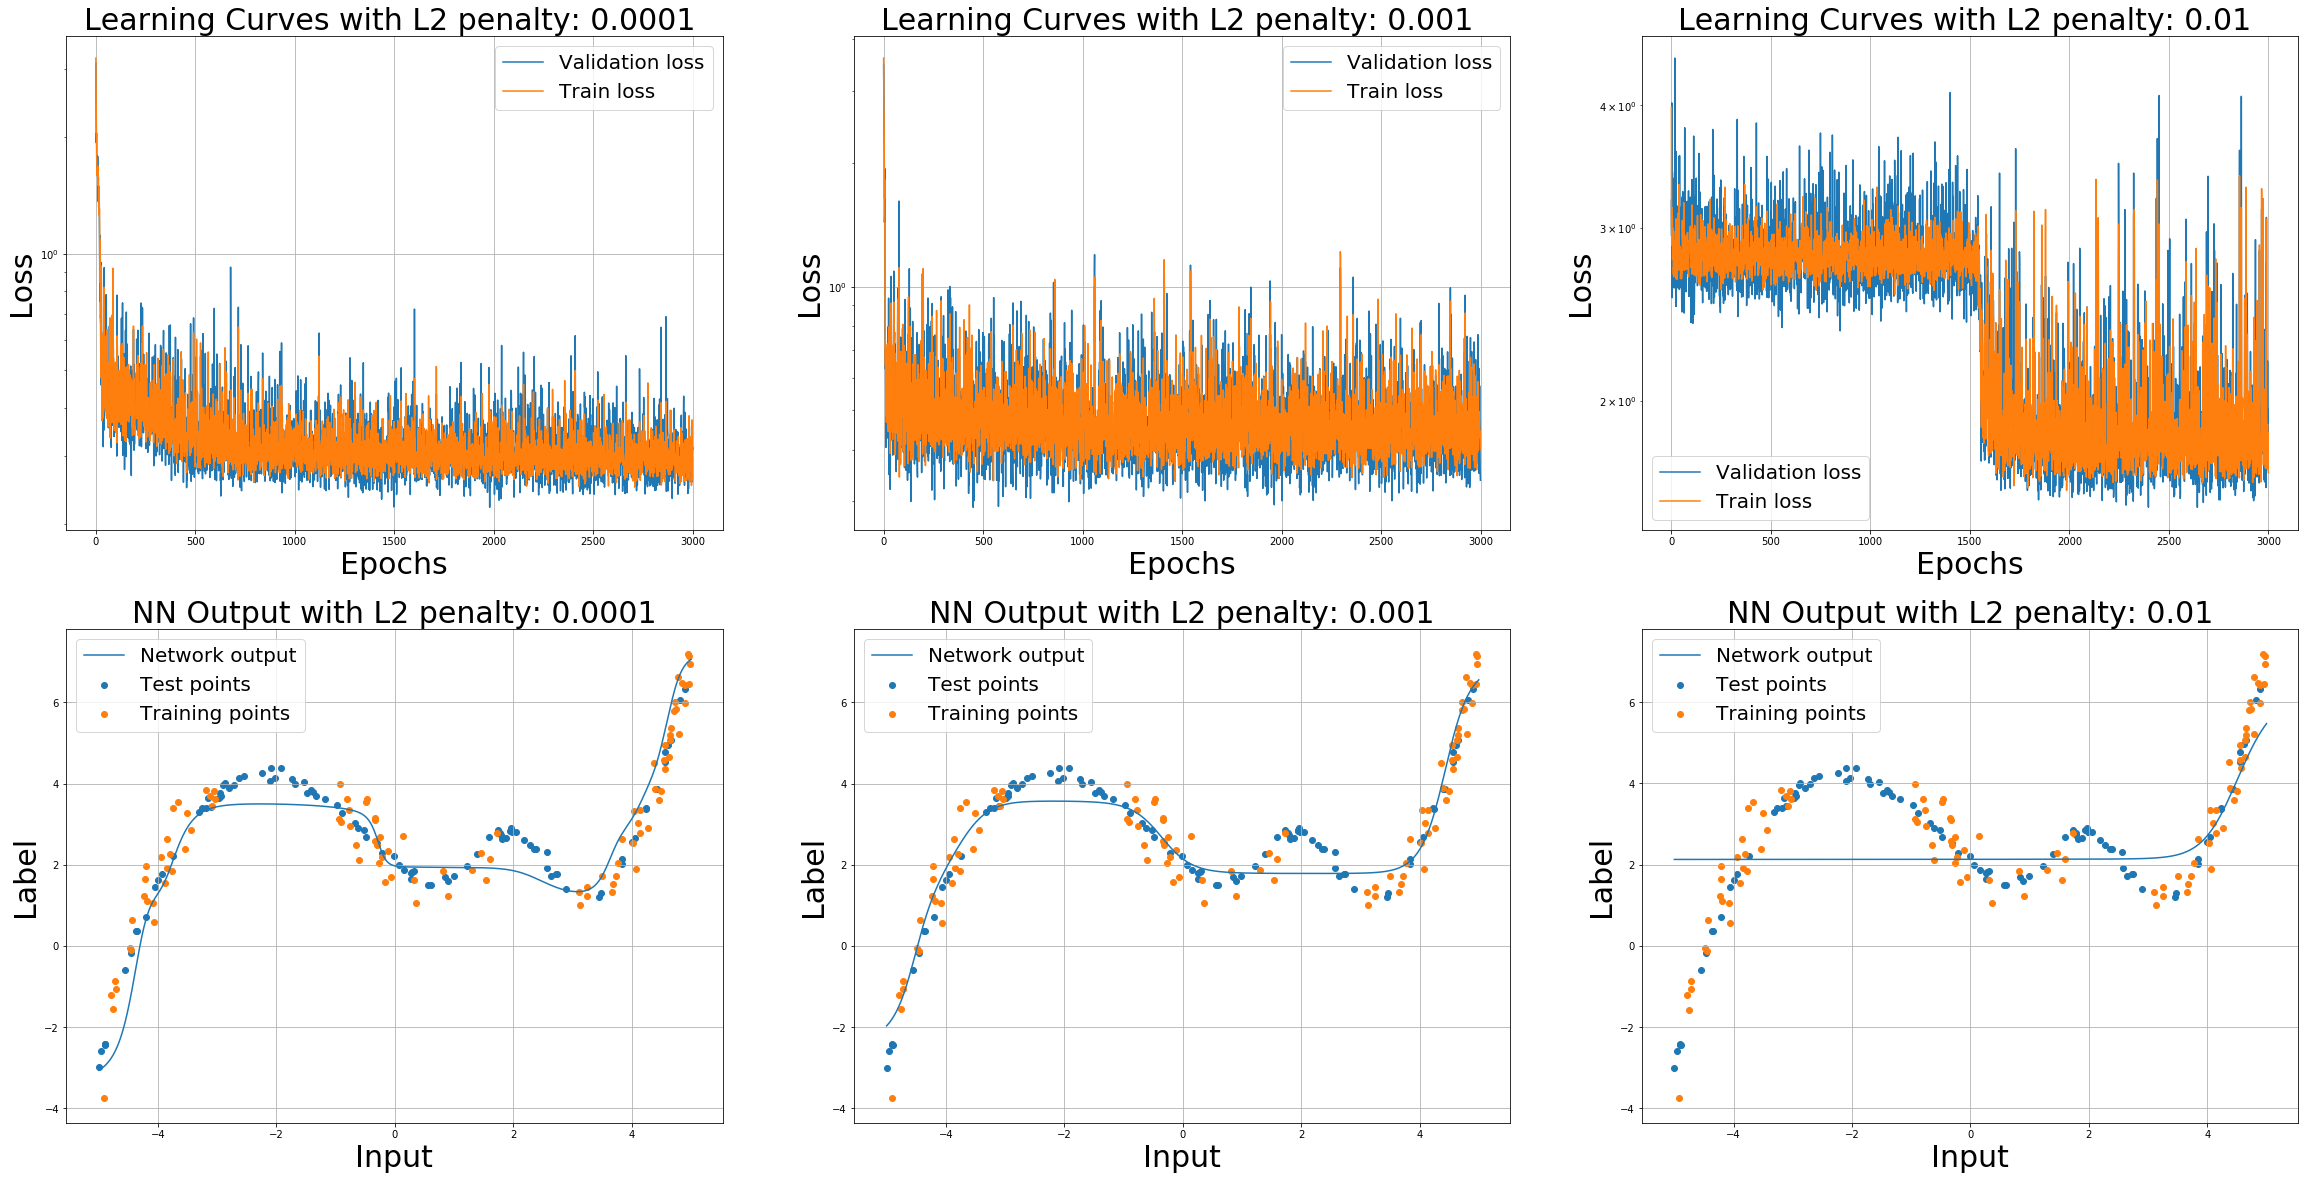

In [27]:
#big plot that compares the different p_drop values
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(40,20))

for i,w in enumerate(weights):
    
    #select proper data
    val = test_losses[i]
    train = train_losses[i]
    net = Networks[i]
    
    # Plot Learning curves
    ax[0,i].semilogy(val, label='Validation loss')
    ax[0,i].semilogy(train, label='Train loss')
    ax[0,i].set_title(f"Learning Curves with L2 penalty: {w} ", fontsize=30)
    ax[0,i].set_xlabel('Epochs', fontsize=30)
    ax[0,i].set_ylabel('Loss', fontsize=30)
    ax[0,i].grid()
    ax[0,i].legend(fontsize=20)
    
    # Input vector
    x_vec = torch.linspace(-5,5,1000)
    x_vec = x_vec.to(device).unsqueeze(-1)

    # Network output
    net.eval()
    with torch.no_grad(): # turn off gradients computation
        y_vec = net(x_vec,additional_layer=True)
        
    # Convert x_vec and y_vec to numpy one dimensional arrays
    x_vec = x_vec.squeeze().cpu().numpy()
    y_vec = y_vec.squeeze().cpu().numpy()

    # Plot NN Output
    ax[1,i].plot(x_vec, y_vec, label='Network output')
    ax[1,i].scatter(test_set[:,0], test_set[:,1], label= "Test points")
    ax[1,i].scatter(training_set[:,0], training_set[:,1], label='Training points')
    ax[1,i].set_title(f"NN Output with L2 penalty: {w}", fontsize=30)
    ax[1,i].grid()
    ax[1,i].set_xlabel('Input', fontsize=30)
    ax[1,i].set_ylabel('Label', fontsize=30)
    ax[1,i].legend(fontsize=20)
    
    
plt.suptitle("Adam's behaviour with L2 penalty",x=0.5,y=1.1,fontsize=20)
plt.show()

As it can be seen from the above plots, the L2 penalty makes it always impossible for the Neural Network to recognize the proper data pattern in the regions where no training points are present.

From left to right we can clearly see the growth of the Regularization intensity. On the leftest output plot, corresponding to a weight norm of $10^{-4}$, we can still see some overfitting behaviours. In the central output  plot (weight norm: $10^{-3}$) the regularization acts in a proper way in the regions where training data are present, while in the last plot(weight norm: $10^{-2}$) the L2 penalty is too strong and it doesn't allow the Neural Network to learn the proper data distribution.

In general we can see that the higher the weight norm parameter is, the noisier the learning curves are, showing a non optimal learning processes for the NN.

### 1.5.2) Regularization: Dropout 

I also wanted to test the behaviour of a non-zeroo dropout probability, therefore I compared the learning processes of my neural network with fixed number of epochs and Adam optimizer and three different $\texttt{p_drop}$ values.

In [26]:
#computational time
start_time = time.time()

#Dropout probabilities
p_drop = [0.1, 0.5, 0.7]

#Initialized Neural Network
Networks = []
train_losses = []
test_losses = []


for i, p in enumerate(p_drop):

    #initialize the network
    NN = initialization(Ni=1, Nh1=100, Nh2=200, Nh3=100, No=1, loss_function=nn.MSELoss(), p_drop=p)
    
    # Define the optimizer
    optimizer = optim.Adam(NN.parameters(), lr=1e-3) 
    
    #train the network
    train_loss, test_loss = new_training(NN, num_epochs=1000, loss_function=nn.MSELoss(), additional_layer=True)
    
    #store learning curves and NN states
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    Networks.append(NN)
    
print("--- %s seconds ---" % (time.time() - start_time))

Network Initialized
Network Trained
Network Initialized
Network Trained
Network Initialized
Network Trained
--- 275.4497330188751 seconds ---


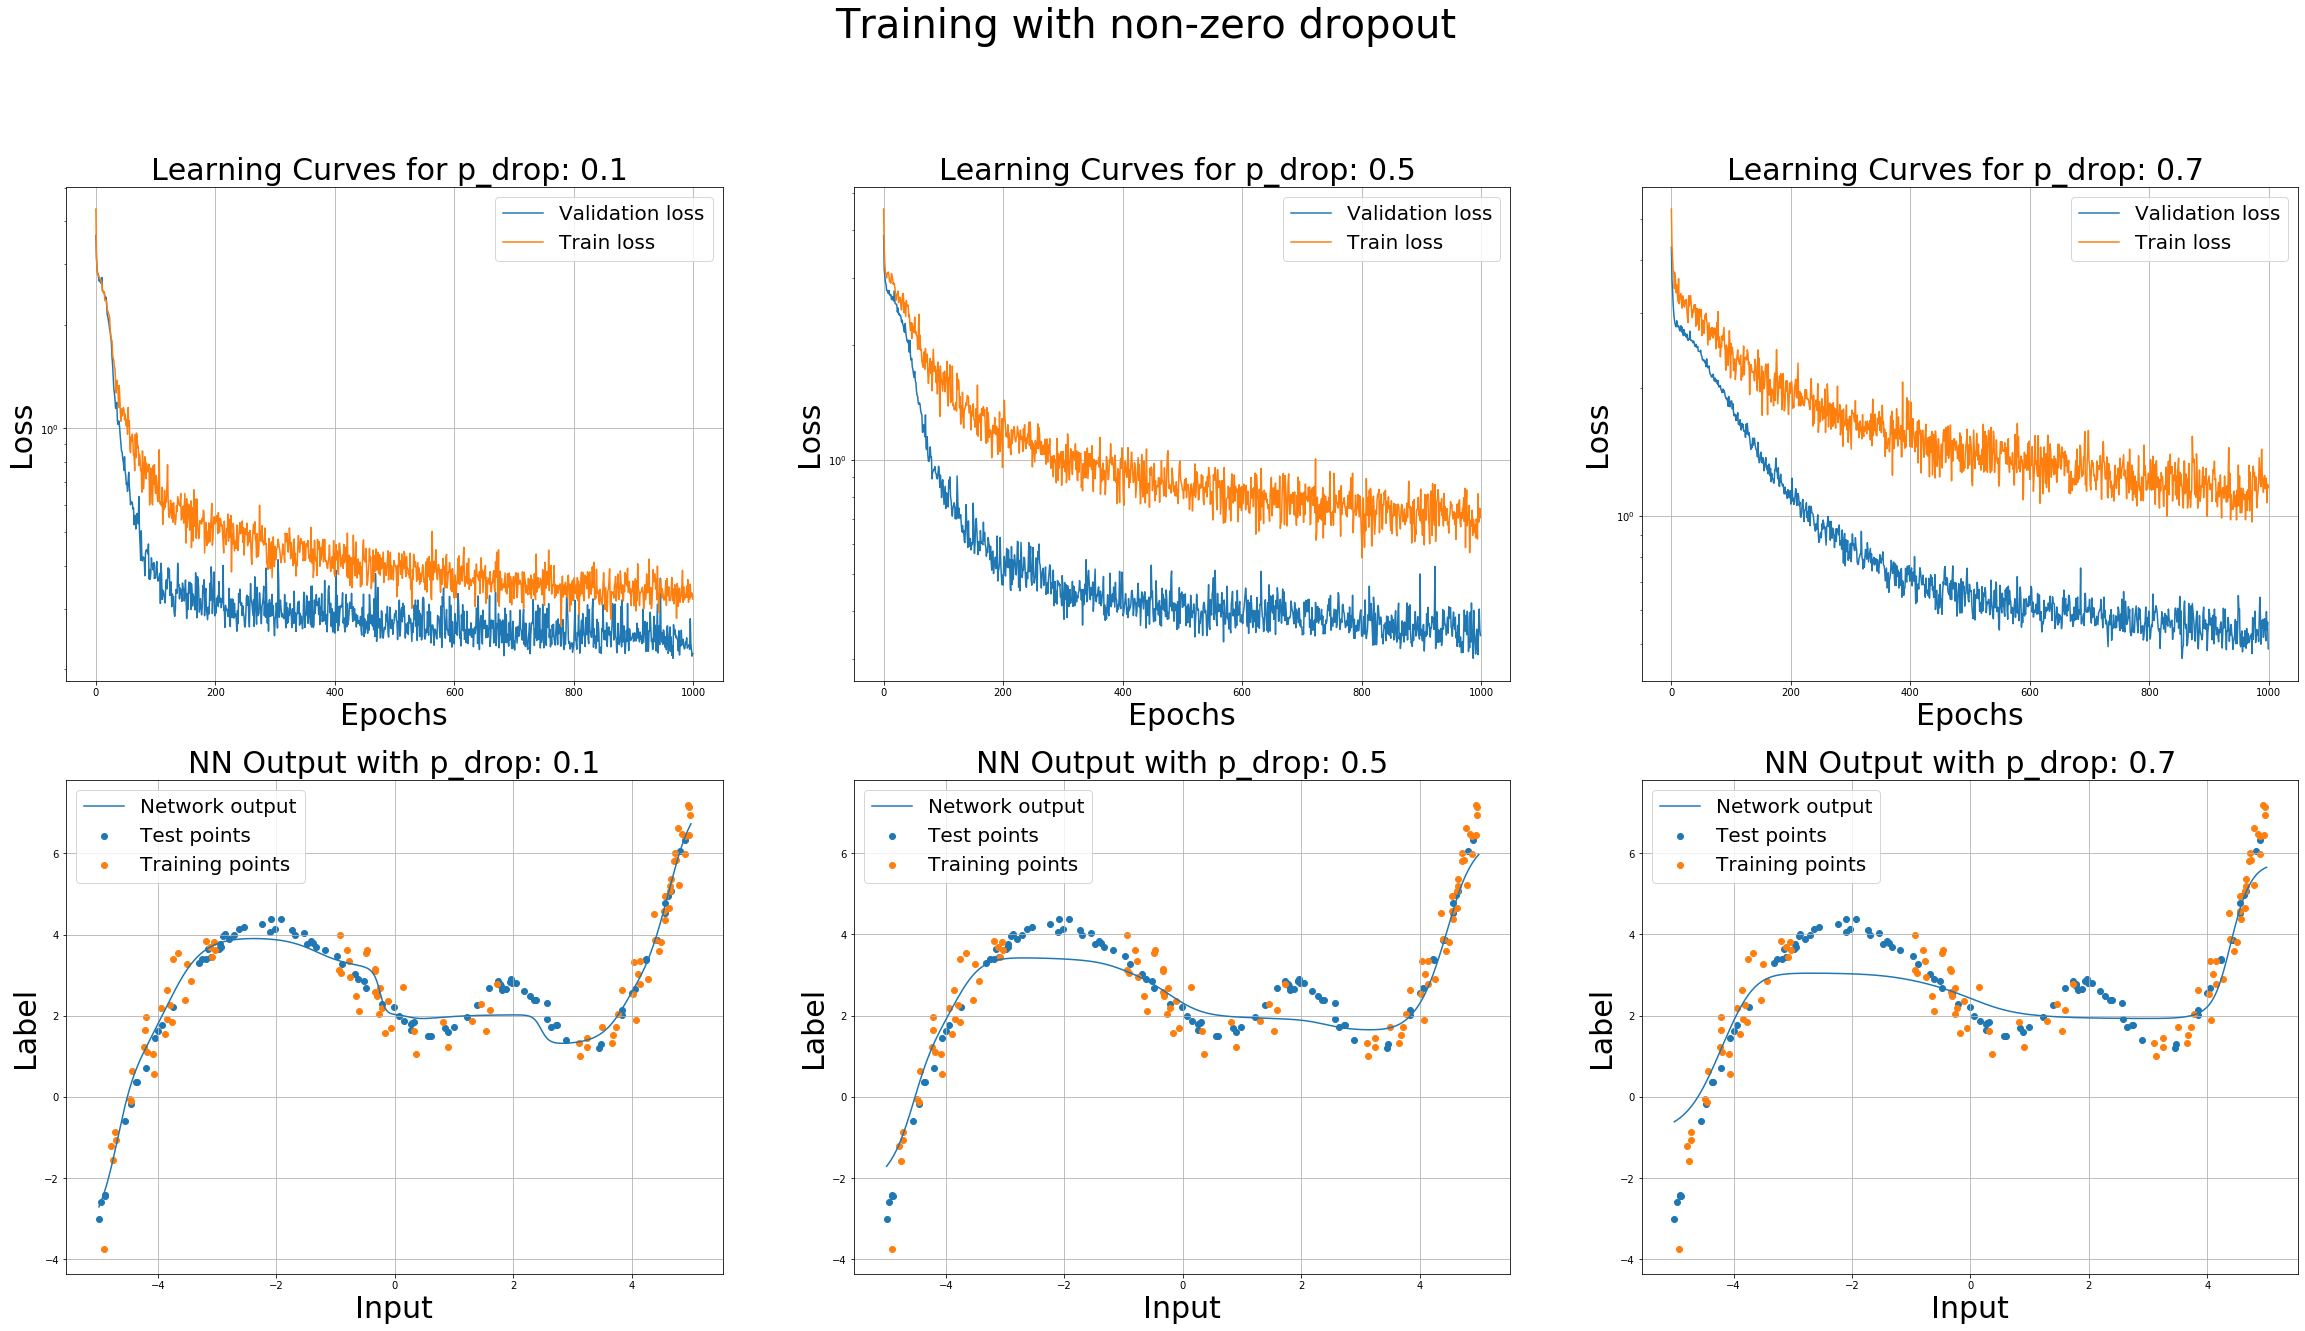

In [27]:
#big plot that compares the different p_drop values
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(40,20))

for i,p in enumerate(p_drop):
    
    #select proper data
    val = test_losses[i]
    train = train_losses[i]
    net = Networks[i]
    
    # Plot Learning curves
    ax[0,i].semilogy(val, label='Validation loss')
    ax[0,i].semilogy(train, label='Train loss')
    ax[0,i].set_title(f"Learning Curves for p_drop: {p} ", fontsize=30)
    ax[0,i].set_xlabel('Epochs', fontsize=30)
    ax[0,i].set_ylabel('Loss', fontsize=30)
    ax[0,i].grid()
    ax[0,i].legend(fontsize=20)
    
    # Input vector
    x_vec = torch.linspace(-5,5,1000)
    x_vec = x_vec.to(device).unsqueeze(-1)

    # Network output
    net.eval()
    with torch.no_grad(): # turn off gradients computation
        y_vec = net(x_vec,additional_layer=True)
        
    # Convert x_vec and y_vec to numpy one dimensional arrays
    x_vec = x_vec.squeeze().cpu().numpy()
    y_vec = y_vec.squeeze().cpu().numpy()

    # Plot NN Output
    ax[1,i].plot(x_vec, y_vec, label='Network output')
    ax[1,i].scatter(test_set[:,0], test_set[:,1], label= "Test points")
    ax[1,i].scatter(training_set[:,0], training_set[:,1], label='Training points')
    ax[1,i].set_title(f"NN Output with p_drop: {p}", fontsize=30)
    ax[1,i].grid()
    ax[1,i].set_xlabel('Input', fontsize=30)
    ax[1,i].set_ylabel('Label', fontsize=30)
    ax[1,i].legend(fontsize=20)
    
    
plt.suptitle("Training with non-zero dropout",x=0.5,y=1.005,fontsize=40)
plt.show()

As we can see from the learning curves, a higher Dropout probability corresponds to a slower convergence. The parameter $\texttt{p_drop}$ is in fact referring to the probability for a neuron to fail, therefore a higher Dropout value represents a Neural Network with a lower effective number of working neurons.

The output plots behave accordingly to the values of the loss. Similarly to the previous plots referring to the study of L2 penalty, also in this case we can perceive the intensity of the Regularization: from left to right, we pass from still seing some signs of overfitting too an over regularized network.

## 1.6) Final Study

For the final study of the Neural Network performances, I used Skorch built-in functions to perform a gridsearch over SGD and Adam's optimal parameters separately.


### 1.6.1) Gridsearch for SGD

For the SGD case, I decide to keep fixed the momentum (0.7) and the weight decay ($10^{-3}$) parameters, both because I wanted to limit the computational effort of the code and because they have been studied previously in the notebook.

The Gridsearch for SGD parameters is performed on the folloowing values:

| parameter | values |
| --- | --- |
| learning rate | [0.001, 0.01, 0.1] |
| epochs | [500,1500,3000] |


In [ ]:
#computational time
start_time = time.time()

net_skorch = NeuralNetRegressor(
    Net(Ni=1, Nh1=100, Nh2=200, Nh3=100, No=1, p_drop=0),
    criterion=nn.MSELoss(),
    optimizer=optim.SGD,
    optimizer__momentum=0.7,
    optimizer__weight_decay=1e-3,
    max_epochs=3000,
    lr=0.001
)

#COMPUTATIONALLY DEMANDING!

params = {
    'lr': [0.001, 0.01, 0.1],
    'max_epochs' : [500, 1500, 3000]
}

gs = GridSearchCV(net_skorch, params, refit=False, cv=4, scoring='neg_root_mean_squared_error')

x = torch.Tensor(training_set[:,0]).float().unsqueeze(-1)

label = torch.Tensor(training_set[:,1]).float().unsqueeze(-1)

gs.fit(x.cpu(), label.cpu())
print(gs.best_score_, gs.best_params_)

print("--- %s seconds ---" % (time.time() - start_time))

The best set of parameters for the SGD case is **learning_rate=0.01** and **epochs=3000**, corresponding to a final **best_score=-2.032** as evaluated from the Skorch functions.

### 1.6.2) Gridsearch for Adam

For the Adam's case the weight decay parameter has been fixed to a value of $5*10^{-4}$, while the Gridsearch has been performed over the following values:

| parameter | values |
| --- | --- |
| learning rate | [0.001, 0.01, 0.1] |
| epochs | [500,1500,3000] |



In [ ]:
#computational time
start_time = time.time()

net_skorch = NeuralNetRegressor(
    Net(Ni=1, Nh1=100, Nh2=200, Nh3=100, No=1, p_drop=0),
    criterion=nn.MSELoss(),
    optimizer=optim.Adam,
    optimizer__weight_decay=5e-4,
    max_epochs=1000,
    lr=0.001
)

#COMPUTATIONALLY DEMANDING!

params = {
    'lr': [0.001, 0.01, 0.1],
    'max_epochs' : [500, 1500, 3000]
}

gs = GridSearchCV(net_skorch, params, refit=False, cv=4, scoring='neg_root_mean_squared_error')

x = torch.Tensor(training_set[:,0]).float().unsqueeze(-1)

label = torch.Tensor(training_set[:,1]).float().unsqueeze(-1)

gs.fit(x.cpu(), label.cpu())
print(gs.best_score_, gs.best_params_)

print("--- %s seconds ---" % (time.time() - start_time))

The best set of parameters for the Adam's case is **learning_rate=0.001** and **epochs=3000**, corresponding to a final **best_score=-1.279** as evaluated from the Skorch functions.

### 1.6.3) Retrain NN with Adam and SGD best parameters

I have eventually retrained the Neural Network with Adam and SGD's best parameters separately because I wanted to visualize their respective results.

In [28]:
#SGD
#computational time
start_time = time.time()

#initialize the network
NN_sgd = initialization(Ni=1, Nh1=100, Nh2=200, Nh3=100, No=1, loss_function=nn.MSELoss(), p_drop=0)

# Define the optimizer
optimizer = optim.SGD(NN_sgd.parameters(), lr=0.01, momentum=0.7, weight_decay=1e-3)

#train the network
train_loss_sgd, test_loss_sgd = new_training(NN_sgd, num_epochs=3000, loss_function=nn.MSELoss(), additional_layer=True)

print("--- %s seconds ---" % (time.time() - start_time))

Network Initialized
Network Trained
--- 211.08934497833252 seconds ---


In [29]:
#ADAM
#computational time
start_time = time.time()

#initialize the network
NN_adam = initialization(Ni=1, Nh1=100, Nh2=200, Nh3=100, No=1, loss_function=nn.MSELoss(), p_drop=0)

# Define the optimizer
optimizer = optim.Adam(NN_adam.parameters(), lr=1e-3, weight_decay=5e-4)

#train the network
train_loss_adam, test_loss_adam = new_training(NN_adam, num_epochs=3000, loss_function=nn.MSELoss(), additional_layer=True)

print("--- %s seconds ---" % (time.time() - start_time))

Network Initialized
Network Trained
--- 270.4131841659546 seconds ---


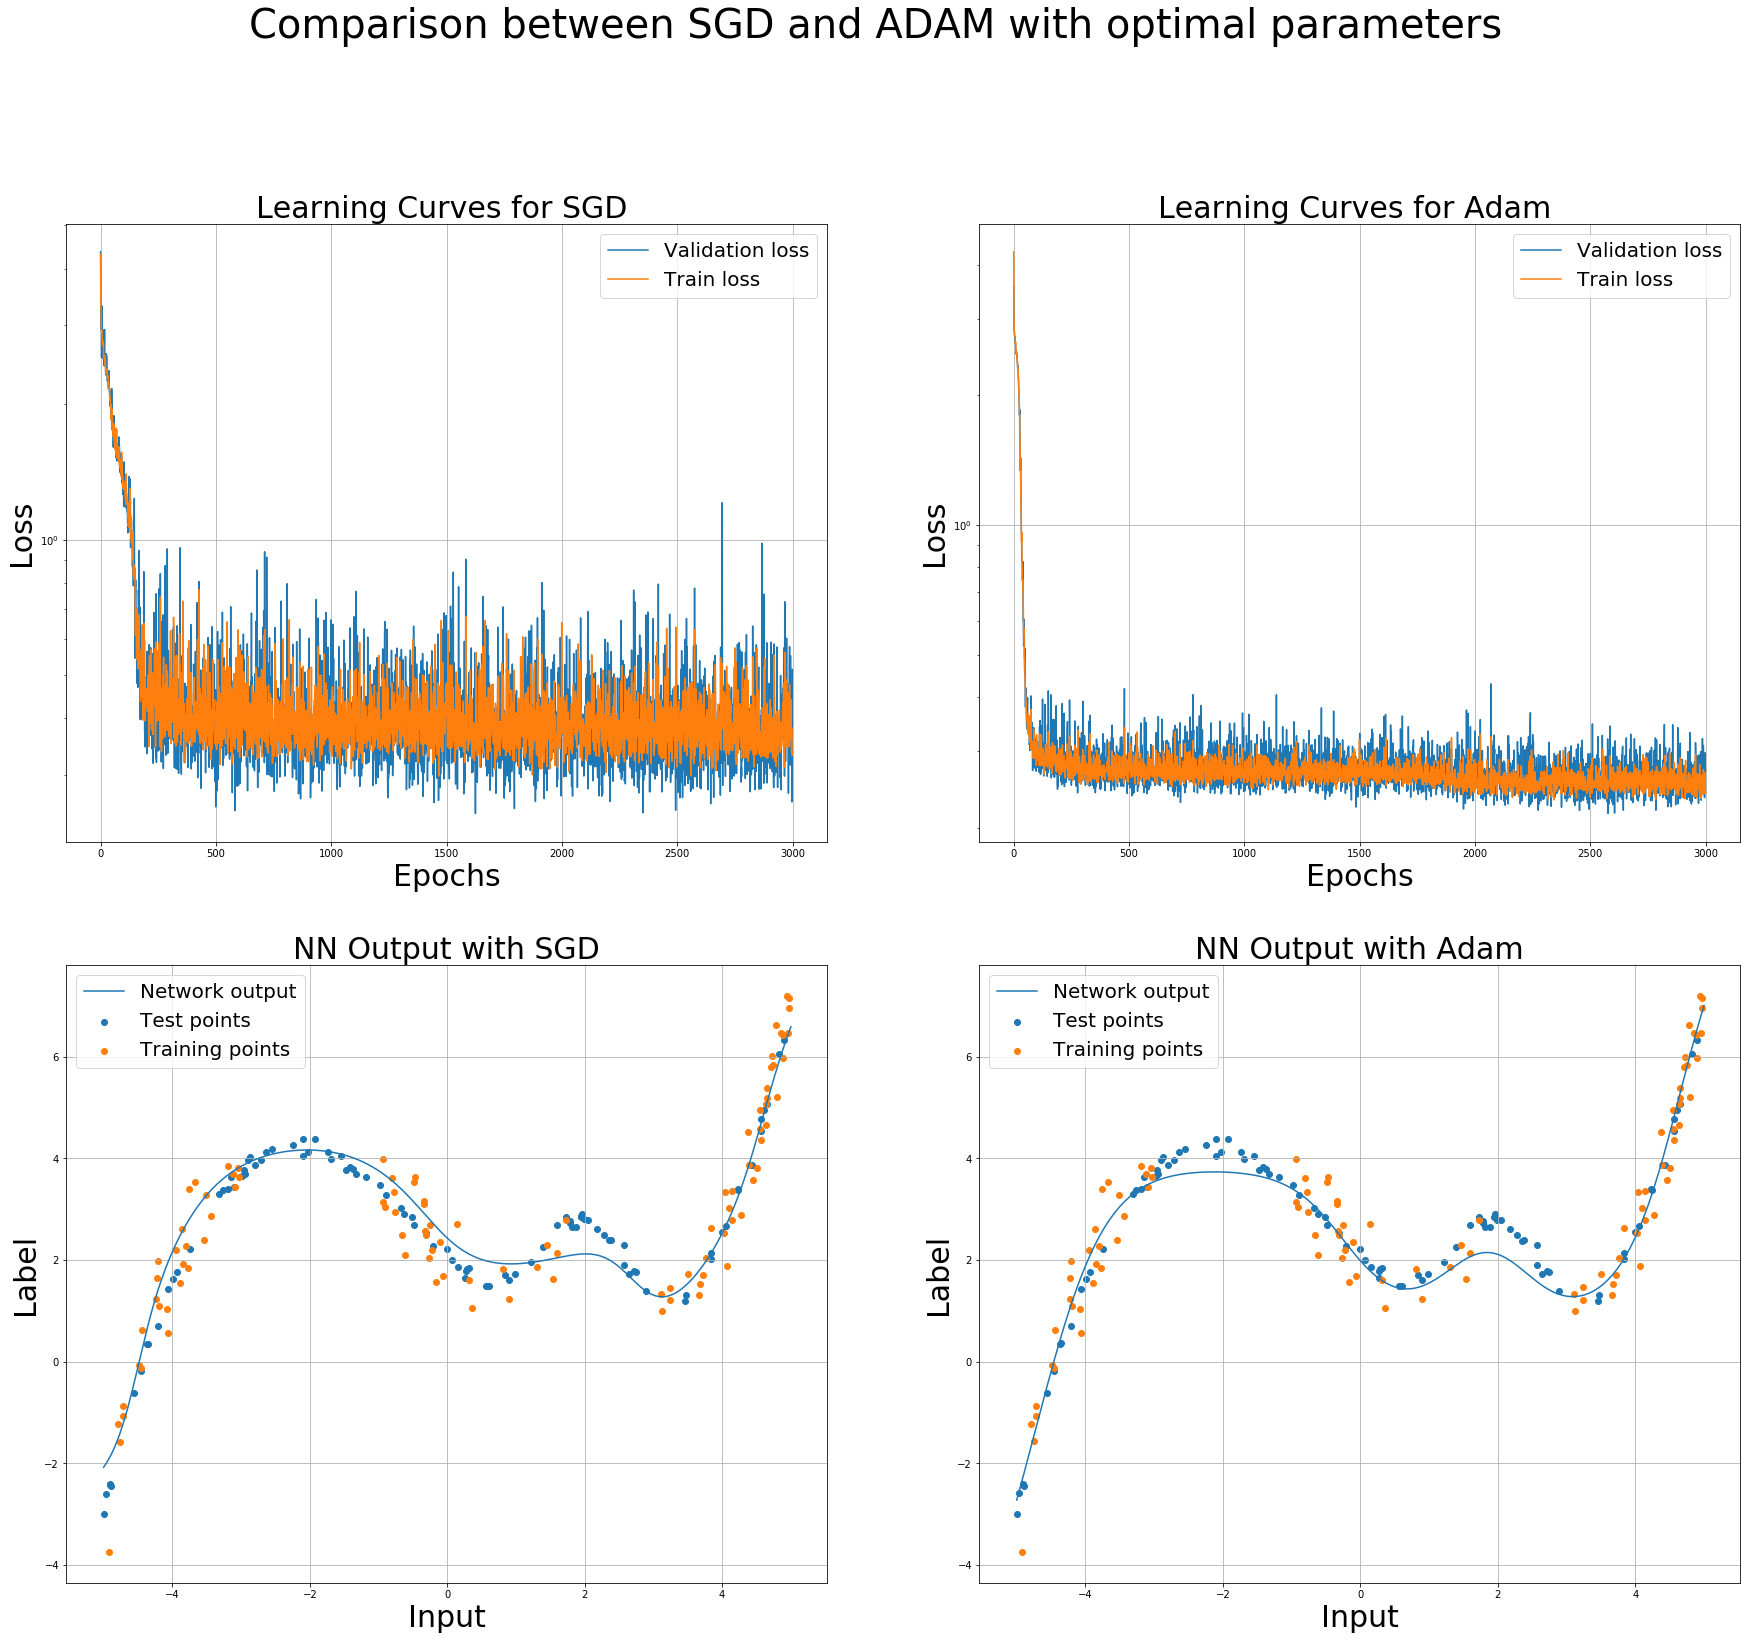

In [31]:
#storing
optimizers = ["SGD","Adam"]
train_losses = [train_loss_sgd, train_loss_adam]
test_losses = [test_loss_sgd, test_loss_adam]
Networks = [NN_sgd, NN_adam]

#big plot that compares the different p_drop values
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(30,25))

for i,opt in enumerate(optimizers):
    
    #select proper data
    val = test_losses[i]
    train = train_losses[i]
    net = Networks[i]
    
    # Plot Learning curves
    ax[0,i].semilogy(val, label='Validation loss')
    ax[0,i].semilogy(train, label='Train loss')
    ax[0,i].set_title(f"Learning Curves for {opt} ", fontsize=30)
    ax[0,i].set_xlabel('Epochs', fontsize=30)
    ax[0,i].set_ylabel('Loss', fontsize=30)
    ax[0,i].grid()
    ax[0,i].legend(fontsize=20)
    
    # Input vector
    x_vec = torch.linspace(-5,5,1000)
    x_vec = x_vec.to(device).unsqueeze(-1)

    # Network output
    net.eval()
    with torch.no_grad(): # turn off gradients computation
        y_vec = net(x_vec,additional_layer=True)
        
    # Convert x_vec and y_vec to numpy one dimensional arrays
    x_vec = x_vec.squeeze().cpu().numpy()
    y_vec = y_vec.squeeze().cpu().numpy()

    # Plot NN Output
    ax[1,i].plot(x_vec, y_vec, label='Network output')
    ax[1,i].scatter(test_set[:,0], test_set[:,1], label= "Test points")
    ax[1,i].scatter(training_set[:,0], training_set[:,1], label='Training points')
    ax[1,i].set_title(f"NN Output with {opt}", fontsize=30)
    ax[1,i].grid()
    ax[1,i].set_xlabel('Input', fontsize=30)
    ax[1,i].set_ylabel('Label', fontsize=30)
    ax[1,i].legend(fontsize=20)
    
    
plt.suptitle("Comparison between SGD and ADAM with optimal parameters",x=0.5,y=1.0005,fontsize=40)
plt.show()

The Neural Network implemented with Adam and its set of best parameters happens to be the best result both from the output plot and the stability and convergence of the learning curves. 

### 1.6.4) Best Result

In [27]:
#create datasets
train_dataset = CsvDataset(training_set, transform=composed_transform)
test_dataset = CsvDataset(test_set, transform=composed_transform)

#Converting to Dataloader Class
train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True, num_workers=0)
test_dataloader  = DataLoader(test_dataset,  batch_size=len(test_dataset), shuffle=False, num_workers=0)

def training_and_testing(NN, num_epochs, loss_function, additional_layer=False):
    
    #train and validation losses computed as KFold means at each epoch
    train_loss_log = []
    test_loss_log = []
    
    
    for epoch_num in range(num_epochs):

        ### TRAIN
        NN.train()
            
        # Move data to device
        train_loss = []
        for sampled_batch in train_dataloader: #5 items per batch
            x_batch = sampled_batch[0].to(device)
            label_batch = sampled_batch[1].to(device)

            # Forward pass
            out = NN(x_batch,additional_layer)

            # Compute loss
            loss = loss_function(out, label_batch)

            # Backpropagation
            NN.zero_grad()
            loss.backward()

            # Update the weights
            optimizer.step()

            # Save train loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            train_loss.append(loss_batch) 
            
            
        ### VALIDATION
        NN.eval() # Evaluation mode 

        with torch.no_grad(): # Disable gradient tracking

            # Move data to device
            test_loss = []
            for sampled_batch in test_dataloader:
                x_batch = sampled_batch[0].to(device)
                label_batch = sampled_batch[1].to(device)

                # Forward pass
                out = NN(x_batch,additional_layer)

                # Compute loss
                loss = loss_function(out, label_batch)

                # Save val loss for this batch
                loss_batch = loss.detach().cpu().numpy()
                test_loss.append(loss_batch)

                
        #save mean loss values for each epoch        
        train_loss_log.append(np.mean(train_loss))
        test_loss_log.append(np.mean(test_loss))
        
    print("Network Trained")
        
    return [train_loss_log, test_loss_log] 

Network Initialized
Network Trained


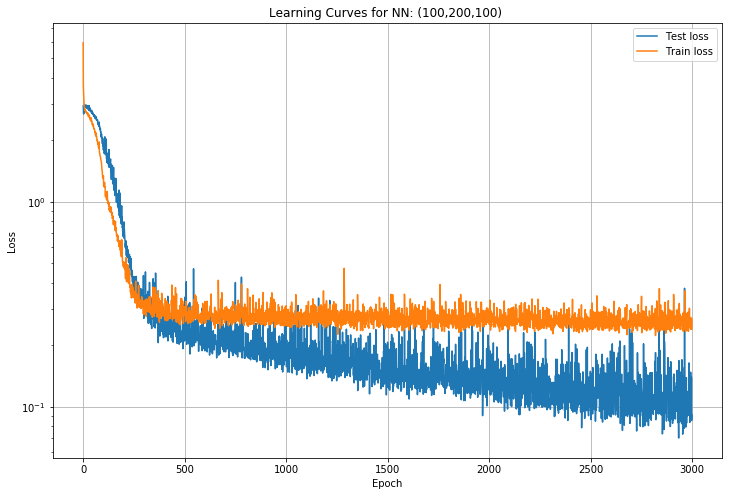

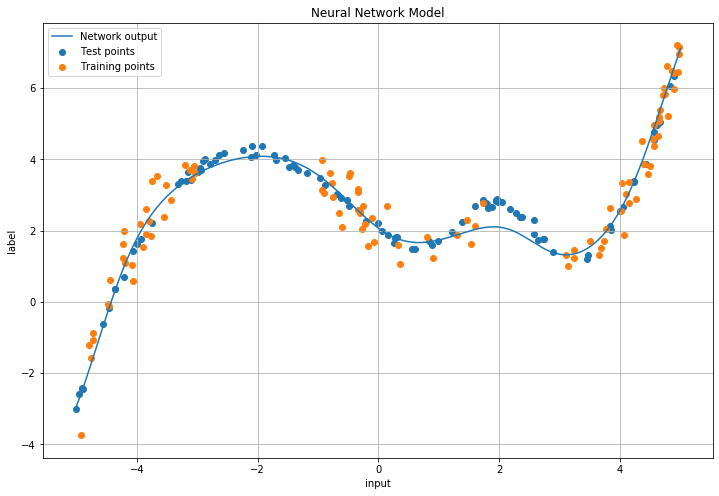

--- 85.4193160533905 seconds ---


In [28]:
#computational time
start_time = time.time()

#initialize the network
NN_adam = initialization(Ni=1, Nh1=100, Nh2=200, Nh3=100, No=1, loss_function=nn.MSELoss(), p_drop=0)

# Define the optimizer
optimizer = optim.Adam(NN_adam.parameters(), lr=1e-3, weight_decay=5e-4)

#train the network
train_loss_adam, test_loss_adam = training_and_testing(NN_adam, num_epochs=3000, loss_function=nn.MSELoss(), additional_layer=True)

# Plot losses
plt.figure(figsize=(12,8))
plt.semilogy(test_loss_adam, label='Test loss')
plt.semilogy(train_loss_adam, label='Train loss')
plt.title(f"Learning Curves for NN: (100,200,100) ")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

#plot output
plot_output(NN_adam,additional_layer=True)

print("--- %s seconds ---" % (time.time() - start_time))

## 1.7) Visualization

## 1.7.1) Weights 

From the comparison of the weights distributions, we can see how the learning process updates the values of the different interconnections between neurons. The starting configuration of weights resembles a random or uniform distribution depending on the hidden layer considered; after training the Neural Network si capable of summarising the gathered information into limited regions of its layers. In the below plots we can see how the NN retains certain features of the data in the distribution of the trained weights.

In [30]:
#initialize the network
NN = initialization(Ni=1, Nh1=100, Nh2=200, Nh3=100, No=1,
                    loss_function=nn.MSELoss(), p_drop=0)

# Define the optimizer
optimizer = optim.Adam(NN.parameters(), lr=1e-3, weight_decay=5e-4)

#train the network
train_loss, test_loss = training_and_testing(NN, num_epochs=1500, loss_function=nn.MSELoss(), additional_layer=True)

#store NN parameters into dict
NN_final_dict = NN.state_dict()

Network Initialized
Network Trained


Network Initialized


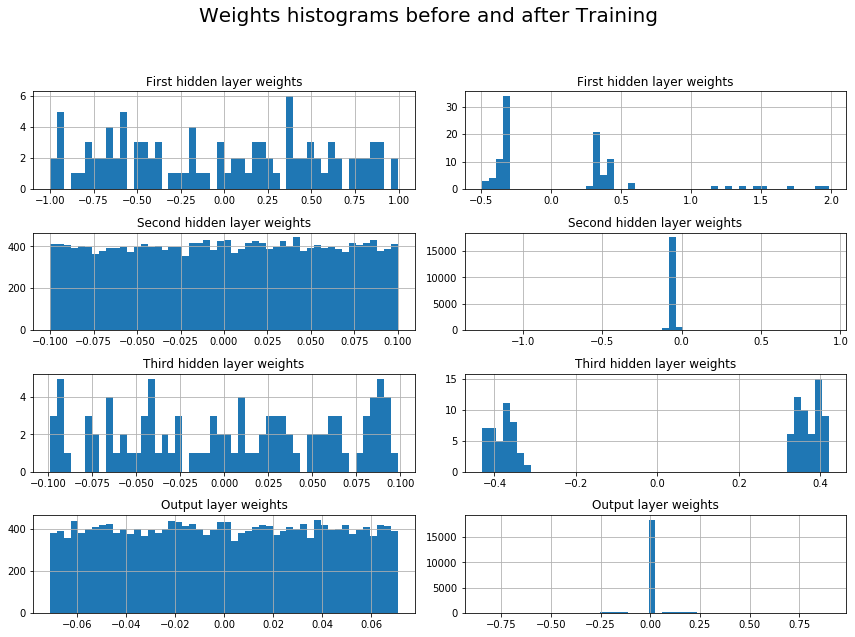

In [31]:
#initialize the network
network = initialization(Ni=1, Nh1=100, Nh2=200, Nh3=100, No=1,
                    loss_function=nn.MSELoss(), p_drop=0)

#dictionaries of NN states state
dictionaries = [network.state_dict(), NN_final_dict]

#plot weights before and after training
fig, axs = plt.subplots(4, 2, figsize=(12,8))

for i,state_dict in enumerate(dictionaries):
    
    #load NN state
    network.load_state_dict(state_dict)
    
    # First hidden layer
    h1_w = network.fc1.weight.data.cpu().numpy()

    # Second hidden layer
    h2_w = network.fc2.weight.data.cpu().numpy()

    #Third hidden layer
    h3_w = network.fc3.weight.data.cpu().numpy()

    # Output layer
    out_w = network.out.weight.data.cpu().numpy()

    # Weights histogram
    axs[0,i].hist(h1_w.flatten(), 50)
    axs[0,i].set_title('First hidden layer weights')
    axs[1,i].hist(h2_w.flatten(), 50)
    axs[1,i].set_title('Second hidden layer weights')
    axs[2,i].hist(out_w.flatten(), 50)
    axs[2,i].set_title('Third hidden layer weights')
    axs[3,i].hist(h3_w.flatten(), 50)
    axs[3,i].set_title('Output layer weights')
    [ax.grid() for ax in axs[:,i]]
    
plt.suptitle("Weights histograms before and after Training",x=0.5,y=1.1,fontsize=20)
plt.tight_layout()
plt.show()

## 1.7.2) Activation function

In the below plots I reported the values ooutputted by the activation functions of each hidden layer with respect to three different received inputs.

In [32]:
def get_activation(layer, input, output):
    global activation
    activation = torch.relu(output)

In [33]:
#register hook
hook_handle_fc1 = NN_adam.fc1.register_forward_hook(get_activation)

### Analyze activations
NN_adam.to(device).eval()
inputs = [-1, 0, 4]
inputs_list = [torch.tensor([x]).float() for x in inputs]
outputs_list_1 = []

with torch.no_grad():
    for inp in inputs_list:
        temp_y = NN_adam(inp.to(device))
        outputs_list_1.append(activation)

# Remove hook
hook_handle_fc1.remove()


#register hook  
hook_handle_fc2 = NN_adam.fc2.register_forward_hook(get_activation)

### Analyze activations
NN_adam.to(device).eval()
inputs = [-3, 0, 2]
inputs_list = [ torch.tensor([x]).float() for x in inputs]
outputs_list_2 = []

with torch.no_grad():
    for inp in inputs_list:
        temp_y = NN_adam(inp.to(device))
        outputs_list_2.append(activation)

# Remove hook
hook_handle_fc2.remove()

#register hook  
hook_handle_fc3 = NN_adam.fc3.register_forward_hook(get_activation)

### Analyze activations
NN_adam.to(device).eval()
inputs = [-3, 0, 2]
inputs_list = [ torch.tensor([x]).float() for x in inputs]
outputs_list_3 = []

with torch.no_grad():
    for inp in inputs_list:
        temp_y = NN_adam(inp.to(device))
        outputs_list_3.append(activation)

# Remove hook
hook_handle_fc3.remove()

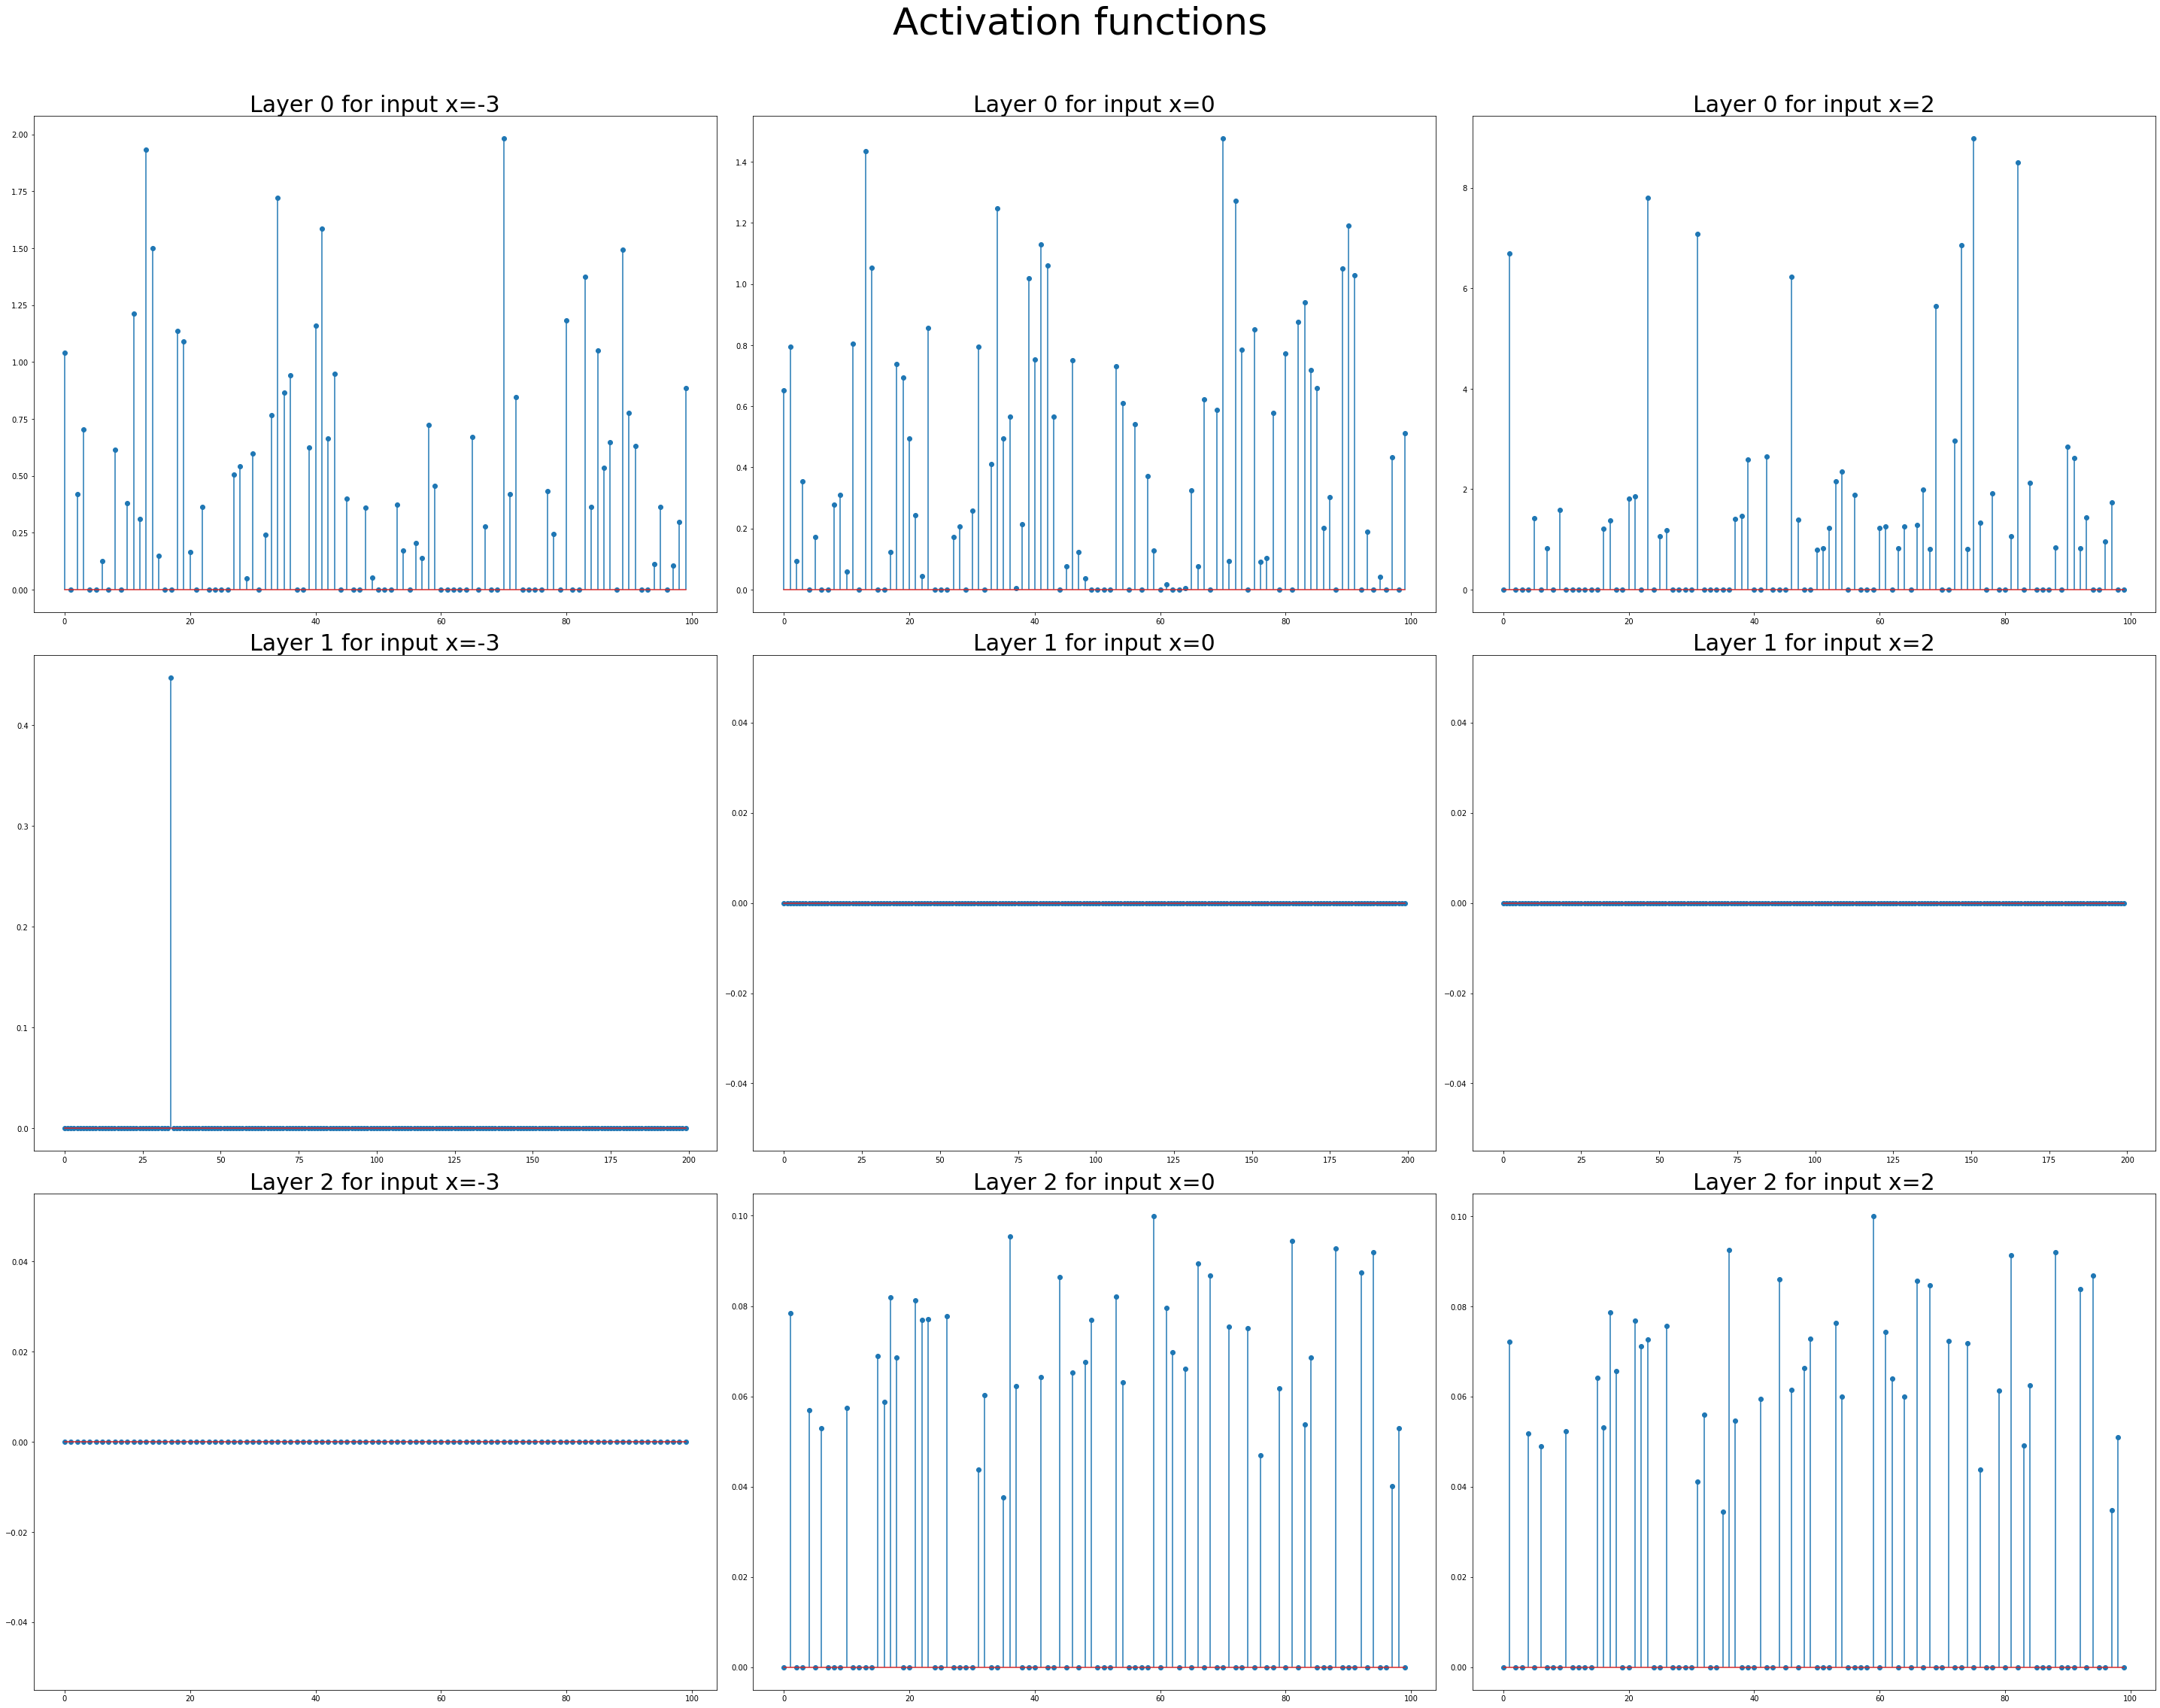

In [34]:
outputs = [outputs_list_1,outputs_list_2,outputs_list_3]

fig,ax = plt.subplots(3,3,figsize=(40,30))

for i in range(3):
    output = outputs[i]
    for j, out in enumerate(output):
        ax[i,j].stem(out.cpu().numpy(),use_line_collection=True)
        ax[i,j].set_title("Layer %d for input x=%.f" %(i,inputs[j]),fontsize=30)
    
plt.suptitle("Activation functions",x=0.5,y=1.05,fontsize=50)
plt.tight_layout()
plt.show()